# Data Exploration Notebook

In [1]:
# Listing 1 — Setup
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# --- Paths: edit these to your project layout ---
PATH_MEMBERSHIP = Path("data/processed/universe_membership_wiki_sp400.csv")
PATH_PRICES_MERGED = Path("data/merged/prices.parquet")
PATH_VOLUME_MERGED = Path("data/merged/volume.parquet")

# Optional (only if you saved pre-augmentation panels / provenance)
PATH_PRICES_STOOQ = Path("data/stooq/prices.parquet")
OUTDIR = Path("figs_data_collection")
OUTDIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Listing 2 — Load
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
prices = pd.read_parquet(PATH_PRICES_MERGED)
volume = pd.read_parquet(PATH_VOLUME_MERGED)

# Ensure index types
prices.index = pd.to_datetime(prices.index)
volume.index = pd.to_datetime(volume.index)



Membership rows: 752
Merged prices shape (dates x tickers): (3774, 853)
Merged volume shape (dates x tickers): (3774, 853)
Dates span: 2010-01-04 → 2024-12-31
Tickers (merged) : 853


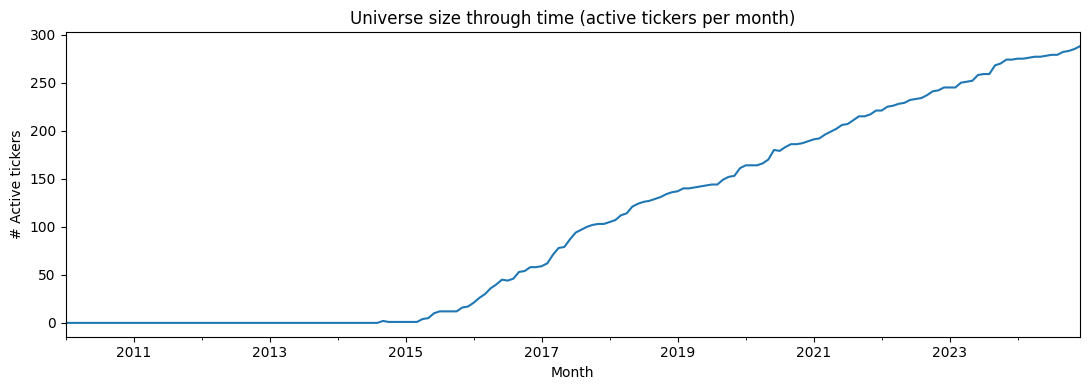

In [3]:
mem2 = mem.copy()
mem2["end"] = mem2["end"].fillna(prices.index.max())
cal_m = pd.date_range(prices.index.min(), prices.index.max(), freq="ME")

def active_count(ts):
    return ((mem2["start"] <= ts) & (mem2["end"] >= ts)).sum()

active_series = pd.Series({ts: active_count(ts) for ts in cal_m}).sort_index()

plt.figure(figsize=(11,4))
active_series.plot()
plt.title("Universe size through time (active tickers per month)")
plt.xlabel("Month"); plt.ylabel("# Active tickers")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_universe_size.png", dpi=160); plt.show()


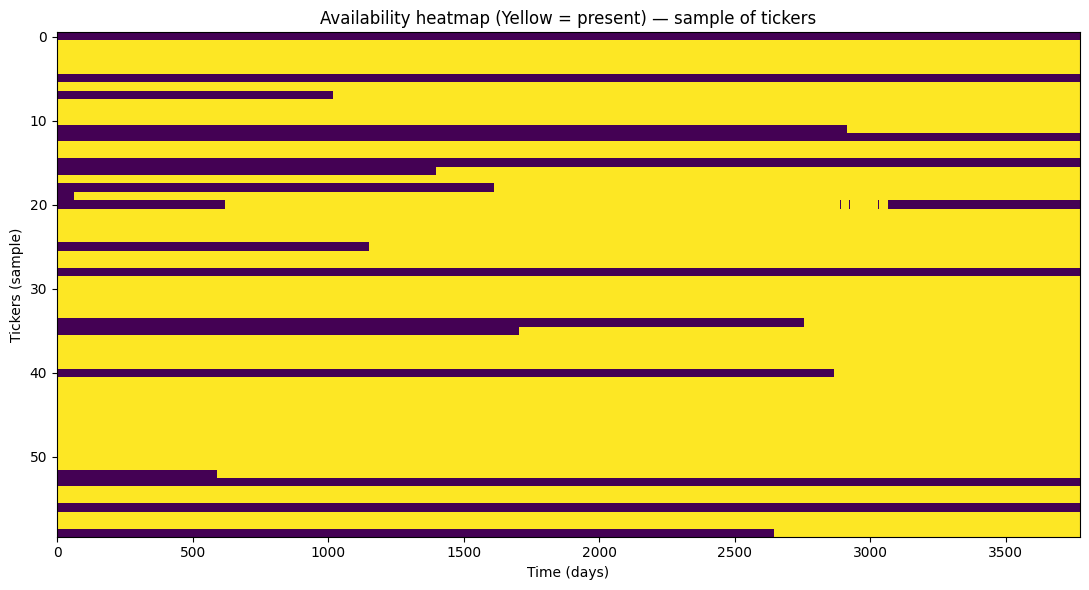

In [4]:
np.random.seed(7)
sample_n = min(60, prices.shape[1])
cols = np.random.choice(prices.columns, size=sample_n, replace=False)
avail = (~prices[cols].isna()).astype(int)

plt.figure(figsize=(11,6))
plt.imshow(avail.T, aspect="auto", interpolation="nearest")
plt.title("Availability heatmap (Yellow = present) — sample of tickers")
plt.xlabel("Time (days)")
plt.ylabel("Tickers (sample)")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_availability_heatmap.png", dpi=160)
plt.show()


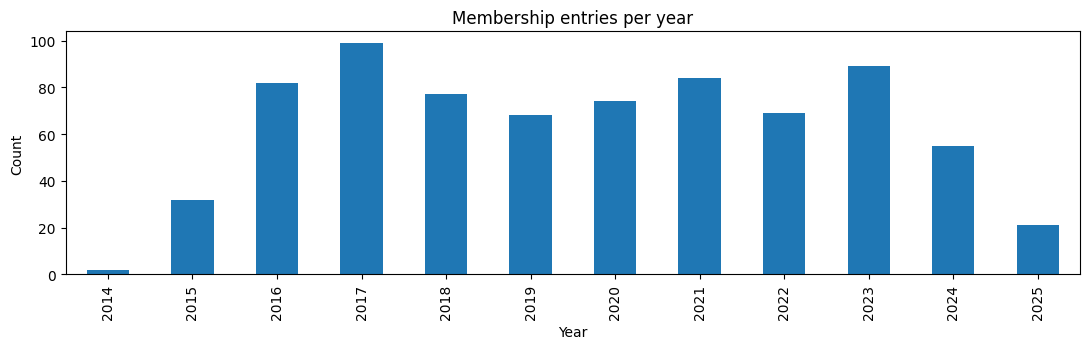

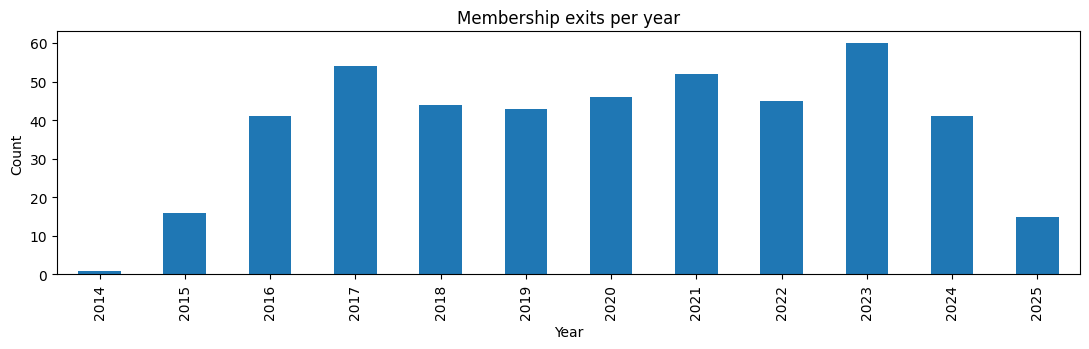

In [5]:
entries = mem["start"].dt.to_period("Y").value_counts().sort_index()
exits   = mem["end"].dropna().dt.to_period("Y").value_counts().sort_index()
years = sorted(set(entries.index.astype(str)) | set(exits.index.astype(str)))

entries = entries.reindex(years).fillna(0).astype(int)
exits   = exits.reindex(years).fillna(0).astype(int)

plt.figure(figsize=(11,3.6))
entries.index = entries.index.astype(str); entries.plot(kind="bar")
plt.title("Membership entries per year"); plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_entries_per_year.png", dpi=160); plt.show()

plt.figure(figsize=(11,3.6))
exits.index = exits.index.astype(str)
exits.plot(kind="bar")
plt.title("Membership exits per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_exits_per_year.png", dpi=160)
plt.show()


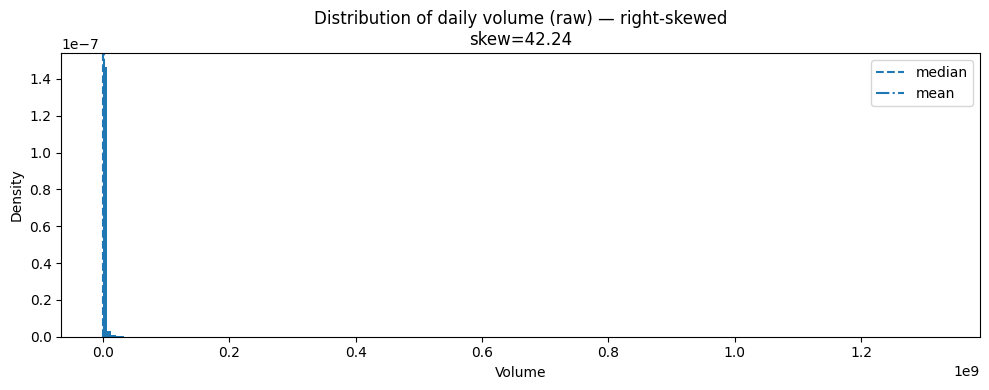

In [6]:
v = volume.stack().dropna()
skew_raw = v.skew()

plt.figure(figsize=(10,4))
plt.hist(v, bins=200, density=True)
plt.title(f"Distribution of daily volume (raw) — right-skewed\nskew={skew_raw:.2f}")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.axvline(v.median(), linestyle="--", label="median")
plt.axvline(v.mean(), linestyle="-.", label="mean")
plt.legend()
plt.tight_layout()
plt.savefig("figs_data_collection/fig_volume_raw.png", dpi=160)
plt.show()

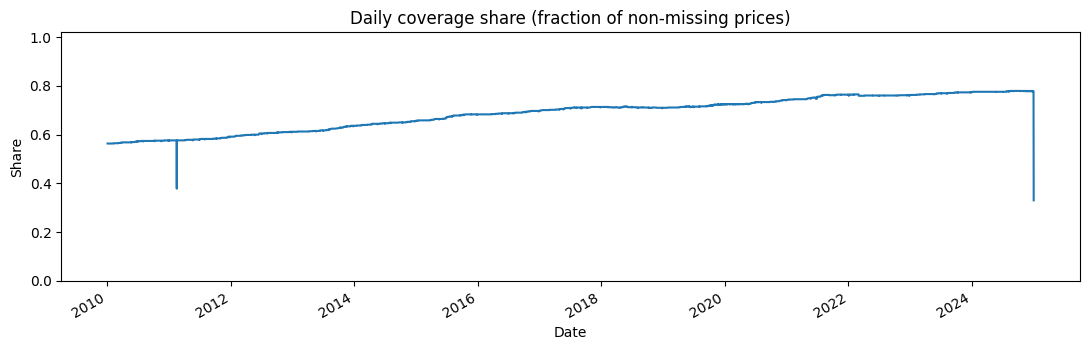

In [7]:
daily_cov = (~prices.isna()).mean(axis=1)
plt.figure(figsize=(11,3.6))
daily_cov.plot()
plt.title("Daily coverage share (fraction of non-missing prices)")
plt.xlabel("Date")
plt.ylabel("Share")
plt.ylim(0, 1.02)
plt.tight_layout()
plt.savefig(OUTDIR/"fig_daily_coverage.png", dpi=160)
plt.show()


In [8]:
# Membership validation (run once)
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

# start <= end
bad_order = mem[mem["start"] > mem["end"]]

# duplicates
dupes = mem.duplicated(["ticker","start","end"]).sum()

# overlapping intervals per ticker
overlap = 0
for _tkr, g in mem.sort_values(["ticker","start"]).groupby("ticker"):
    if (g["start"].shift(-1) <= g["end"]).fillna(False).any():
        overlap += 1

# coverage in panels after symbol normalisation
sym_in_panel = set(prices.columns)
missing_syms = set(mem["ticker"]) - sym_in_panel


Bad intervals: 15
Duplicate rows: 0
Tickers with overlaps: 0
Membership tickers not in merged panels: 0


In [9]:
# Clean membership intervals
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

# Flag inverted intervals
inv = mem["end"] < mem["start"]

# Heuristic 1: swap if the swap yields a positive duration and <= 15 years (guard against typos)
dur = (mem["start"] - mem["end"]).abs().dt.days
swap_ok = inv & (dur <= 15*365)
mem.loc[swap_ok, ["start","end"]] = mem.loc[swap_ok, ["end","start"]].values

# Heuristic 2: drop any remaining inverted rows (can also log to a CSV for manual audit)
drop_idx = mem.index[ mem["end"] < mem["start"] ]
if len(drop_idx):
    mem.loc[drop_idx].to_csv("figs_exploration/membership_bad_intervals.csv", index=False)
    mem = mem.drop(index=drop_idx)

# Clip to the market data span
lo, hi = prices.index.min(), prices.index.max()
mem["start"] = mem["start"].clip(lower=lo, upper=hi)
mem["end"]   = mem["end"].clip(lower=lo, upper=hi)

# Re-run the checks
bad_order = (mem["start"] > mem["end"]).sum()
overlap = 0
for _tkr, g in mem.sort_values(["ticker","start"]).groupby("ticker"):
    if (g["start"].shift(-1) <= g["end"]).fillna(False).any():
        overlap += 1


# Save a cleaned copy for downstream steps
mem.to_csv("data/processed/universe_membership_clean.csv", index=False)


Inverted intervals to review: 15
After clean → bad intervals: 0 | tickers with overlaps: 0


In [10]:
PATH_MEMBERSHIP_CLEAN = Path("data/processed/universe_membership_clean.csv")

mem = pd.read_csv(PATH_MEMBERSHIP_CLEAN, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

bad = int((mem["start"] > mem["end"]).sum())
dups = int(mem.duplicated(["ticker","start","end"]).sum())
overlap = sum(
    (g.sort_values("start")["start"].shift(-1) <= g["end"]).fillna(False).any()
    for _, g in mem.groupby("ticker")
)
missing = len(set(mem["ticker"]) - set(prices.columns))
pd.DataFrame({"bad_intervals":[bad], "duplicates":[dups], "overlaps":[overlap], "tickers_not_in_panel":[missing]})


,bad_intervals,duplicates,overlaps,tickers_not_in_panel
0,0,0,0,0


In [11]:
sym_in_panel = set(prices.columns)
missing_syms = set(mem["ticker"]) - sym_in_panel

Membership tickers not in merged panels: 0


{'is_datetimeindex': True, 'is_monotonic_increasing': True, 'num_duplicate_dates': 0}


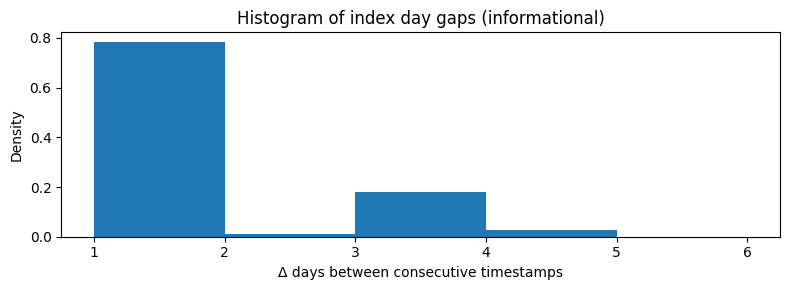

In [12]:
idx = prices.index
qa_a = {
    "is_datetimeindex": isinstance(idx, pd.DatetimeIndex),
    "is_monotonic_increasing": idx.is_monotonic_increasing,
    "num_duplicate_dates": int(pd.Index(idx).duplicated().sum()),
}


# show distribution of day gaps
gaps = pd.Series(idx).diff().dt.days.dropna()
plt.figure(figsize=(8,3))
plt.hist(gaps, bins=range(int(gaps.min()), int(gaps.max())+2), density=True)
plt.title("Histogram of index day gaps (informational)")
plt.xlabel("Δ days between consecutive timestamps"); plt.ylabel("Density")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_index_day_gaps.png", dpi=160); plt.show()

# Hard assertions for the record (will raise if violated)
assert qa_a["is_datetimeindex"], "Index is not a DatetimeIndex."
assert qa_a["is_monotonic_increasing"], "Index is not sorted ascending."
assert qa_a["num_duplicate_dates"] == 0, "Duplicate dates present."

In [ ]:
    plt.savefig(OUTDIR / fname, dpi=180)